In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
scene_list = ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']

In [3]:
IMG_SIZE = 224

def process_image(image_path,img_size=IMG_SIZE):
    """
    Take an image file path and turn image into a Tensor.
    """
    image = tf.io.read_file(image_path) # Read image file
    image = tf.image.decode_jpeg(image,channels=3) # Turn the image into 3 channels RGB
    image = tf.image.convert_image_dtype(image,tf.float32) # Turn the value 0-255 to 0-1
    image = tf.image.resize(image,size=[img_size,img_size]) # Resize the image to 224x224
    return image 

In [4]:
BATCH_SIZE = 32

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data out of image (X)
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating testing data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only file path (no label)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

In [5]:
model = tf.keras.models.load_model("models/scene-classifier-10-epochs.h5",custom_objects={'KerasLayer':hub.KerasLayer})

Creating testing data batches...


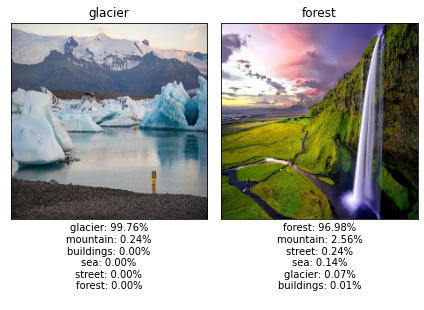

In [6]:
# Test the real images
predicted_list = []
custom_path= "images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path) if fname !=".DS_Store"]
custom_data = create_data_batches(custom_image_paths,test_data=True)
custom_preds = model.predict(custom_data)
for preds in custom_preds:
    temp_list = []
    for i,pred in enumerate(preds,0): 
        temp_list.append([pred,scene_list[i]])
    predicted_list.append(temp_list)
custom_preds_label = [scene_list[np.argmax(cp)] for cp in custom_preds]
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)
string_list = []
for preds in predicted_list:
    string = ""
    for pred in sorted(preds,reverse=True):
        string+= pred[1]+f": {pred[0]*100:.2f}%\n"
    string_list.append(string)
s = len(custom_images)
if s>1:
    fig, axs = plt.subplots(1, s, figsize=(s*3, 5), tight_layout=True)
    for i, image in enumerate(custom_images):
        axs[i].set_xlabel(string_list[i])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(custom_preds_label[i])
        axs[i].imshow(image)
else:
    plt.subplots(1, s, figsize=(s*3, 5), tight_layout=True)
    plt.xlabel(string_list[0])
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_preds_label[0])
    plt.imshow(image)